Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [85]:
%%capture
!pip install category_encoders==2.*

# Working locally:
DATA_PATH = '../data/'

### Import Libraries

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 75)
pd.set_option("display.max_rows", 75)

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split

In [138]:
def clean_up_binary_columns(cell_contents):
  if isinstance(cell_contents, str):
    return 1
  else:
    return 0

In [139]:
def wrangle(filepath):
  df = pd.read_csv(filepath, parse_dates=['DATE'], index_col='DATE')

  # Drop Columns with a high number of NaNs
  df.dropna(axis=1, thresh=300, inplace=True)
 
  # High Cardinality Categorical Columns
  categorical_cols = df.select_dtypes('object').columns
  threshold = 10
  high_card_cols = [col for col in categorical_cols if df[col].nunique() > threshold]
  df.drop(high_card_cols, axis=1, inplace=True)

  # Drop 'UNIQUE KEY' column
  df = df.drop(columns='UNIQUE KEY')
  df = df.drop(columns='BOROUGH')
  #Feature engineering 
  df['Total_fatalities'] = df['PERSONS KILLED'] + df['PEDESTRIANS KILLED'] + df['CYCLISTS KILLED'] + df['MOTORISTS KILLED']
  df['Total_injured'] = df['PERSONS INJURED'] + df['PEDESTRIANS INJURED'] + df['CYCLISTS INJURED'] + df['MOTORISTS INJURED']
  df['Total_victims'] = df['Total_fatalities'] + df['Total_injured']
  
  df = df.dropna(axis=0, subset=['ZIP CODE'])

  return df

df = wrangle(DATA_PATH+'database.csv')  

print(df.shape)
df.head()

(338329, 14)


,ZIP CODE,LATITUDE,LONGITUDE,PERSONS INJURED,PERSONS KILLED,PEDESTRIANS INJURED,PEDESTRIANS KILLED,CYCLISTS INJURED,CYCLISTS KILLED,MOTORISTS INJURED,MOTORISTS KILLED,Total_fatalities,Total_injured,Total_victims
DATE,,,,,,,,,,,,,,
2015-01-01,11358.0,40.751847,-73.787862,0,0,0,0,0,0,0,0,0,0,0
2015-01-01,11205.0,40.689445,-73.955121,0,0,0,0,0,0,0,0,0,0,0
2015-01-01,11213.0,40.673845,-73.925080,0,0,0,0,0,0,0,0,0,0,0
2015-01-01,11203.0,40.656684,-73.929896,2,0,0,0,0,0,2,0,0,4,4
2015-01-01,11105.0,40.776519,-73.915920,0,0,0,0,0,0,0,0,0,0,0


In [140]:
df.isnull().sum()

ZIP CODE                   0
LATITUDE               29381
LONGITUDE              29381
PERSONS INJURED            0
PERSONS KILLED             0
PEDESTRIANS INJURED        0
PEDESTRIANS KILLED         0
CYCLISTS INJURED           0
CYCLISTS KILLED            0
MOTORISTS INJURED          0
MOTORISTS KILLED           0
Total_fatalities           0
Total_injured              0
Total_victims              0
dtype: int64

## Split The Data 

In [141]:
y = df['Total_victims']
X = df.drop(columns='Total_victims')

In [165]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [166]:
# Common class is the baseline
print("Baseline Accuracy", y_train.value_counts(normalize=True)[0])

Baseline Accuracy 0.819732662784542


In [167]:

model_lr = make_pipeline(SimpleImputer(), 
                      StandardScaler(), 
                      LogisticRegression())

model_lr.fit(X_train, y_train)

C:\Users\arnel\anaconda3\envs\unit2\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [168]:

model_rf = make_pipeline(SimpleImputer(),  
                      RandomForestClassifier())

model_rf.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [169]:
print("Training Accuracy - Logistic Regression", model_lr.score(X_train, y_train))
print("Validation Accuracy - Logistic Regression", model_lr.score(X_val, y_val))

Training Accuracy - Logistic Regression 0.9955443797423681
Validation Accuracy - Logistic Regression 0.9956649858037242


In [173]:
print("Training Accuracy - Random Forest", model_rf.score(X_train, y_train))
print("Validation Accuracy - Random Forest", model_rf.score(X_val, y_val))

Training Accuracy - Random Forest 1.0
Validation Accuracy - Random Forest 0.9995969511594371


In [171]:
df.corr()

,ZIP CODE,LATITUDE,LONGITUDE,PERSONS INJURED,PERSONS KILLED,PEDESTRIANS INJURED,PEDESTRIANS KILLED,CYCLISTS INJURED,CYCLISTS KILLED,MOTORISTS INJURED,MOTORISTS KILLED,Total_fatalities,Total_injured,Total_victims
ZIP CODE,1.000000,-0.157026,0.097987,0.059371,0.003096,0.000531,0.000671,-0.005455,0.001656,0.064026,0.003900,0.003119,0.059411,0.059456
LATITUDE,-0.157026,1.000000,-0.902413,-0.006026,-0.001597,0.003553,-0.000921,0.000628,-0.000524,-0.008347,-0.001315,-0.001607,-0.006105,-0.006173
LONGITUDE,0.097987,-0.902413,1.000000,0.006509,-0.000169,-0.001640,-0.000335,-0.006250,-0.000594,0.009445,0.000475,-0.000165,0.006559,0.006538
PERSONS INJURED,0.059371,-0.006026,0.006509,1.000000,0.012449,0.314345,0.001073,0.185196,0.002106,0.847379,0.019954,0.012399,0.984308,0.983183
PERSONS KILLED,0.003096,-0.001597,-0.000169,0.012449,1.000000,0.004404,0.792314,-0.003238,0.293652,0.012302,0.526401,0.998889,0.012508,0.060338
PEDESTRIANS INJURED,0.000531,0.003553,-0.001640,0.314345,0.004404,1.000000,0.008149,-0.028918,-0.002060,-0.046740,-0.002682,0.004382,0.327407,0.327045
PEDESTRIANS KILLED,0.000671,-0.000921,-0.000335,0.001073,0.792314,0.008149,1.000000,-0.003486,-0.000223,0.000633,-0.000358,0.790257,0.002050,0.039904
CYCLISTS INJURED,-0.005455,0.000628,-0.006250,0.185196,-0.003238,-0.028918,-0.003486,1.000000,0.002366,-0.034391,-0.002159,-0.003236,0.194777,0.194282
CYCLISTS KILLED,0.001656,-0.000524,-0.000594,0.002106,0.293652,-0.002060,-0.000223,0.002366,1.000000,0.001904,-0.000138,0.292889,0.001829,0.015857
MOTORISTS INJURED,0.064026,-0.008347,0.009445,0.847379,0.012302,-0.046740,0.000633,-0.034391,0.001904,1.000000,0.020710,0.012329,0.885570,0.884614


C:\Users\arnel\anaconda3\envs\unit2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\arnel\anaconda3\envs\unit2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\arnel\anaconda3\envs\unit2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     91519
           1       0.00      0.00      0.00        43
           2       1.00      1.00      1.00     14720
           3       0.98      0.97      0.98      1152
           4       0.99      0.99      0.99      2534
           5       0.00      0.00      0.00        35
           6       0.97      0.99      0.98       980
           7       0.00      0.00      0.00         9
           8       0.65      0.90      0.75       323
           9       0.36      0.48      0.41        50
          10       0.00      0.00      0.00       137
          11       0.00      0.00      0.00         2
          12       0.03      0.01      0.02        80
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00         6
          16       0.20      0.09      0.13        11
          17       0.00    

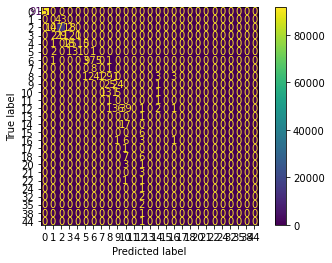

In [174]:
print(classification_report(y_val, model_lr.predict(X_val)))
plot_confusion_matrix(model_lr, X_val, y_val)
plt.show()

C:\Users\arnel\anaconda3\envs\unit2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\arnel\anaconda3\envs\unit2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\arnel\anaconda3\envs\unit2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\arnel\anaconda3\envs\

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     91519
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00     14720
           3       1.00      1.00      1.00      1152
           4       1.00      1.00      1.00      2534
           5       0.94      0.94      0.94        35
           6       0.99      0.99      0.99       980
           7       0.75      0.33      0.46         9
           8       0.98      0.98      0.98       323
           9       0.92      0.98      0.95        50
          10       0.98      0.97      0.97       137
          11       1.00      0.50      0.67         2
          12       0.96      0.94      0.95        80
          13       0.00      0.00      0.00         1
          14       0.94      0.94      0.94        17
          15       1.00      0.83      0.91         6
          16       0.90      0.82      0.86        11
          17       0.00    

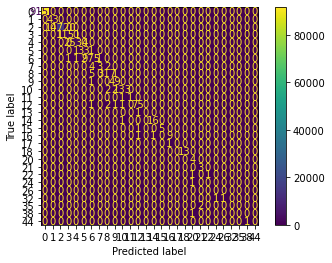

In [175]:
print(classification_report(y_val, model_rf.predict(X_val)))
plot_confusion_matrix(model_rf, X_val, y_val)
plt.show()